In [2]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt

In [3]:
dfs = []
for model_name in os.listdir('output'):
    dirname = os.path.join('output', model_name)
    model_tag, model_size, skip_rate = model_name.split('-')
    skip_rate = float(skip_rate)
    for filename in os.listdir(dirname):
        if filename.endswith('.csv'):
            filepath = os.path.join(dirname, filename)
            df = pd.read_csv(filepath)
            df = df.set_index('key')
            df.loc['skip', 'value'] = skip_rate
            df.loc['model_size', 'value'] = model_size 
            dfs.append(df)

In [17]:
dfs[0]

,value
key,
name,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...
skip,0.4
bandwidth,732160
mem_limit,1073741824
allocation_strategy,FIRST_FIT
eviction_strategy,WEIGHTED_BELADY
total_time,14560.9
idle_rate,0.983717
compute_time,14560.9


In [4]:
data = pd.concat(dfs, axis=1).T.reset_index()

In [5]:
for x in ['mem_limit', 'bandwidth', 'skip', 'total_time', 'idle_rate', 'h2d_time', 'd2h_time', 'duration(ms)']:
    data[x] = data[x].astype(float)

Does Stochastic Depth helps saving communication?

skip, bandwidth, mem_limit, -> total_time, idle_time 
with stochastic depth it saves more time than barely the computation. 

for each model size, plot a curve where the time/idle rate changes with the mem_limit/bandwidth


In [6]:
best_strategy_data = data.loc[data.groupby(['model_size', 'skip', 'bandwidth', 'mem_limit'])['total_time'].idxmin()]

In [7]:
best_strategy_data

key,index,name,skip,bandwidth,mem_limit,allocation_strategy,eviction_strategy,total_time,idle_rate,compute_time,h2d_time,d2h_time,duration(ms),model_size
2239,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,182272.0,1.073742e+09,BEST_FIT,BELADY,61589.400,0.995261,61589.4,61588.6,56295.4,133014935.0,124M
2198,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,182272.0,2.147484e+09,FIRST_FIT,LRU,291.893,0.000000,291.893,0.0,0.0,77062381.0,124M
2214,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,182272.0,4.294967e+09,FIRST_FIT,WEIGHTED_LRU,291.893,0.000000,291.893,0.0,0.0,87606502.0,124M
2199,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,182272.0,8.589935e+09,BEST_FIT,BELADY,291.893,0.000000,291.893,0.0,0.0,97778411.0,124M
2200,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,182272.0,1.717987e+10,FIRST_FIT,LRU,291.893,0.000000,291.893,0.0,0.0,103045175.0,124M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.4,3072000.0,1.073742e+09,BEST_FIT,WEIGHTED_BELADY,43444.300,0.978450,43444.3,43443.0,39279.8,890814795.0,774M
1132,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.4,3072000.0,2.147484e+09,BEST_FIT,WEIGHTED_BELADY,38265.100,0.975533,38265.1,38263.7,34435.0,903397586.0,774M
1162,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.4,3072000.0,4.294967e+09,FIRST_FIT,BELADY,31097.600,0.969893,31097.6,31096.2,28056.9,556302325.0,774M
1356,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.4,3072000.0,8.589935e+09,BEST_FIT,BELADY,18673.000,0.949861,18673,18671.6,17017.3,657183463.0,774M


In [8]:
best_allocation_strategy = best_strategy_data['allocation_strategy'].value_counts()
best_eviction_strategy = best_strategy_data['eviction_strategy'].value_counts()
best_allocation_strategy, best_eviction_strategy

(allocation_strategy
 BEST_FIT     165
 FIRST_FIT    130
 Name: count, dtype: int64,
 eviction_strategy
 BELADY             135
 WEIGHTED_BELADY     95
 LRU                 29
 WEIGHTED_LRU        26
 FIRST_FIT           10
 Name: count, dtype: int64)

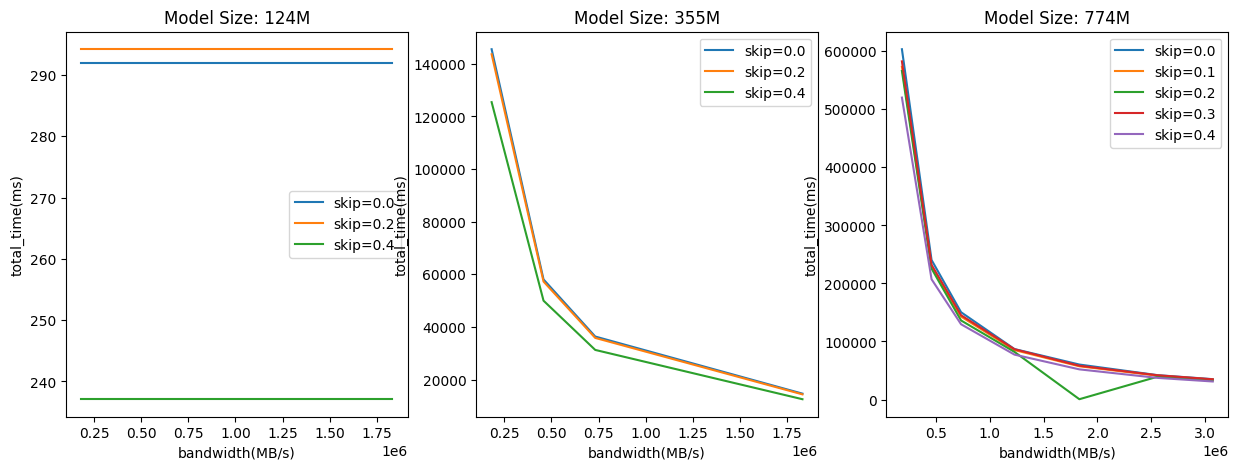

In [11]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
model_size2ax = {"124M": axes[0], "355M": axes[1], "774M": axes[2]}
for k, ax in model_size2ax.items():
    ax.set_title(f"Model Size: {k}")
for (model_size, skip_rate, mem_limit), group in best_strategy_data.groupby(['model_size', 'skip', 'mem_limit']):
    if mem_limit != 4*1073741824: continue 
    ax = model_size2ax[model_size]
    # try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
    sorted_group = group.sort_values('bandwidth')
    sorted_group.plot(ax=ax, x='bandwidth', y='total_time', label=f'skip={skip_rate}')
    ax.set_xlabel('bandwidth(MB/s)')
    ax.set_ylabel('total_time(ms)')
    # except:
    #     print('error')
    #     print(group)

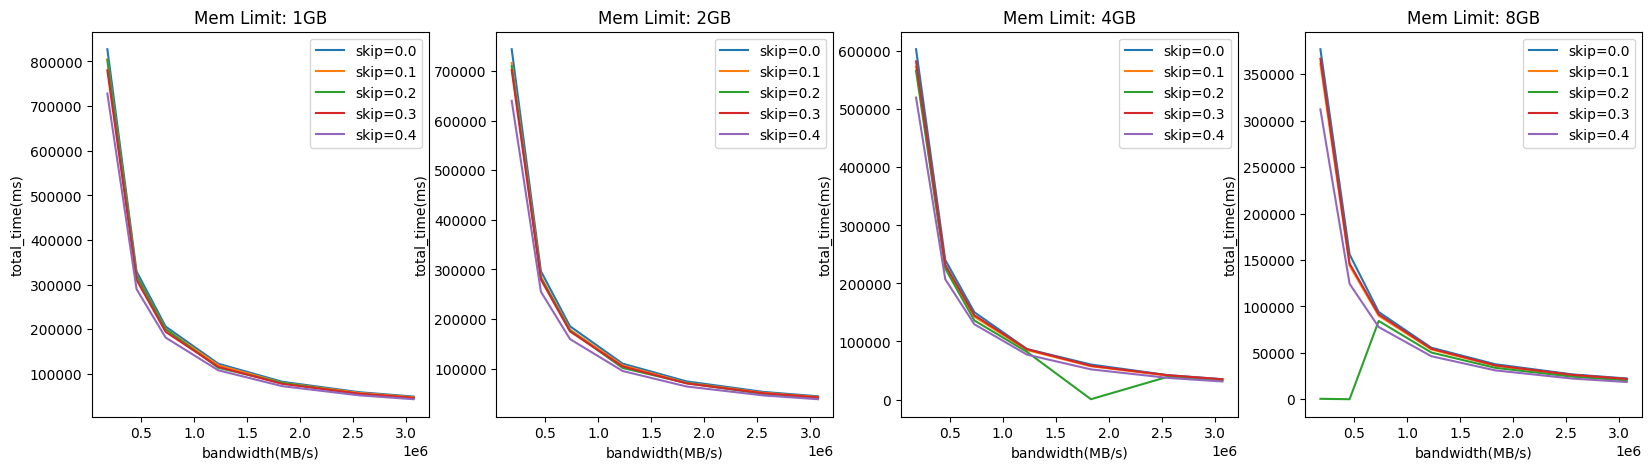

In [16]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
d = {1:0, 2:1, 4:2, 8:3}
mem_limit2ax = lambda x: axes[d[x //1073741824]]
for k, v in d.items():
    axes[v].set_title(f"Mem Limit: {k}GB")
    
for (model_size, skip_rate, mem_limit), group in best_strategy_data.groupby(['model_size', 'skip', 'mem_limit']):
    if model_size != '774M': continue 
    if mem_limit > 8*1073741824: continue
    ax = mem_limit2ax(mem_limit)
    try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
        sorted_group = group.sort_values('bandwidth')
        sorted_group.plot(ax=ax, x='bandwidth', y='total_time', label=f'skip={skip_rate}')
        ax.set_xlabel('bandwidth(MB/s)')
        ax.set_ylabel('total_time(ms)')
    except:
        print('error')
        print(group)

In [48]:
def draw_with_bw(ax, model_size = '774M', mem_limit = 8*1073741824):
    desired_data = best_strategy_data.loc[(best_strategy_data['model_size'] == model_size) & (best_strategy_data['mem_limit'] == mem_limit) & (best_strategy_data['bandwidth'] >= 715*1024)]
    desired_data['bandwidth'] = desired_data['bandwidth'].apply(lambda x: round(x/(1024**2), 3))
    tmp = desired_data.set_index(['bandwidth','skip'])['total_time'].unstack() 
    tmp = tmp.T 
    tmp['geomean'] = tmp.apply(lambda x: x.prod()**(1/len(x)), axis=1)
    tmp = tmp.T
    print(tmp.loc['geomean'])
    tmp.plot.bar(ax=ax, rot=45)
    ax.set_xlabel('Bandwidth(GB/s)')
    ax.set_ylabel('Total Time(ms)')
    ax.set_title(f'Model Size: {model_size}, Mem: {mem_limit/1073741824}GB')


In [49]:
def draw_with_mem_limit(ax, model_size, mem_bandwidth = 715*1024):
    desired_data = best_strategy_data.loc[(best_strategy_data['model_size'] == model_size) & (best_strategy_data['bandwidth'] == mem_bandwidth) & (best_strategy_data['mem_limit'] <= 8*1073741824)]
    desired_data['mem_limit'] = desired_data['mem_limit'].apply(lambda x: round(x/(1024**3), 0))
    tmp = desired_data.set_index(['mem_limit','skip'])['total_time'].unstack() 
    tmp = tmp.T 
    tmp['geomean'] = tmp.apply(lambda x: x.prod()**(1/len(x)), axis=1)
    tmp = tmp.T
    print(tmp.loc['geomean'])
    tmp.plot.bar(ax=ax, rot=45)
    ax.set_xlabel('mem_limit(GB)')
    ax.set_ylabel('total_time(ms)')
    ax.set_title(f"Model Size: {model_size}, Bandwidth: {mem_bandwidth/1024}MB/s")

/tmp/ipykernel_350264/1642564473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_data['mem_limit'] = desired_data['mem_limit'].apply(lambda x: round(x/(1024**3), 0))
/tmp/ipykernel_350264/530572976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_data['bandwidth'] = desired_data['bandwidth'].apply(lambda x: round(x/(1024**2), 3))


skip
0.0    152482.916706
0.1    146494.000084
0.2    142078.758948
0.3    145801.688202
0.4    130746.926263
Name: geomean, dtype: float64
skip
0.0    41252.596050
0.1    39658.873454
0.2    37267.969832
0.3    40291.304916
0.4    34247.461658
Name: geomean, dtype: float64


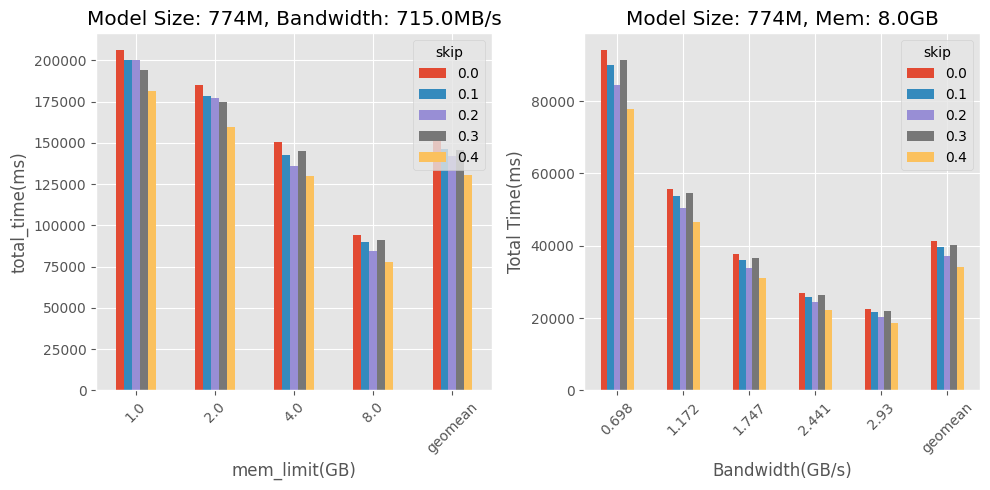

In [51]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2,figsize=(10,5), tight_layout=True)
draw_with_mem_limit(axes[0], '774M')
draw_with_bw(axes[1], '774M')
fig.savefig('skip_rate.pdf')
fig.savefig('skip_rate.png')

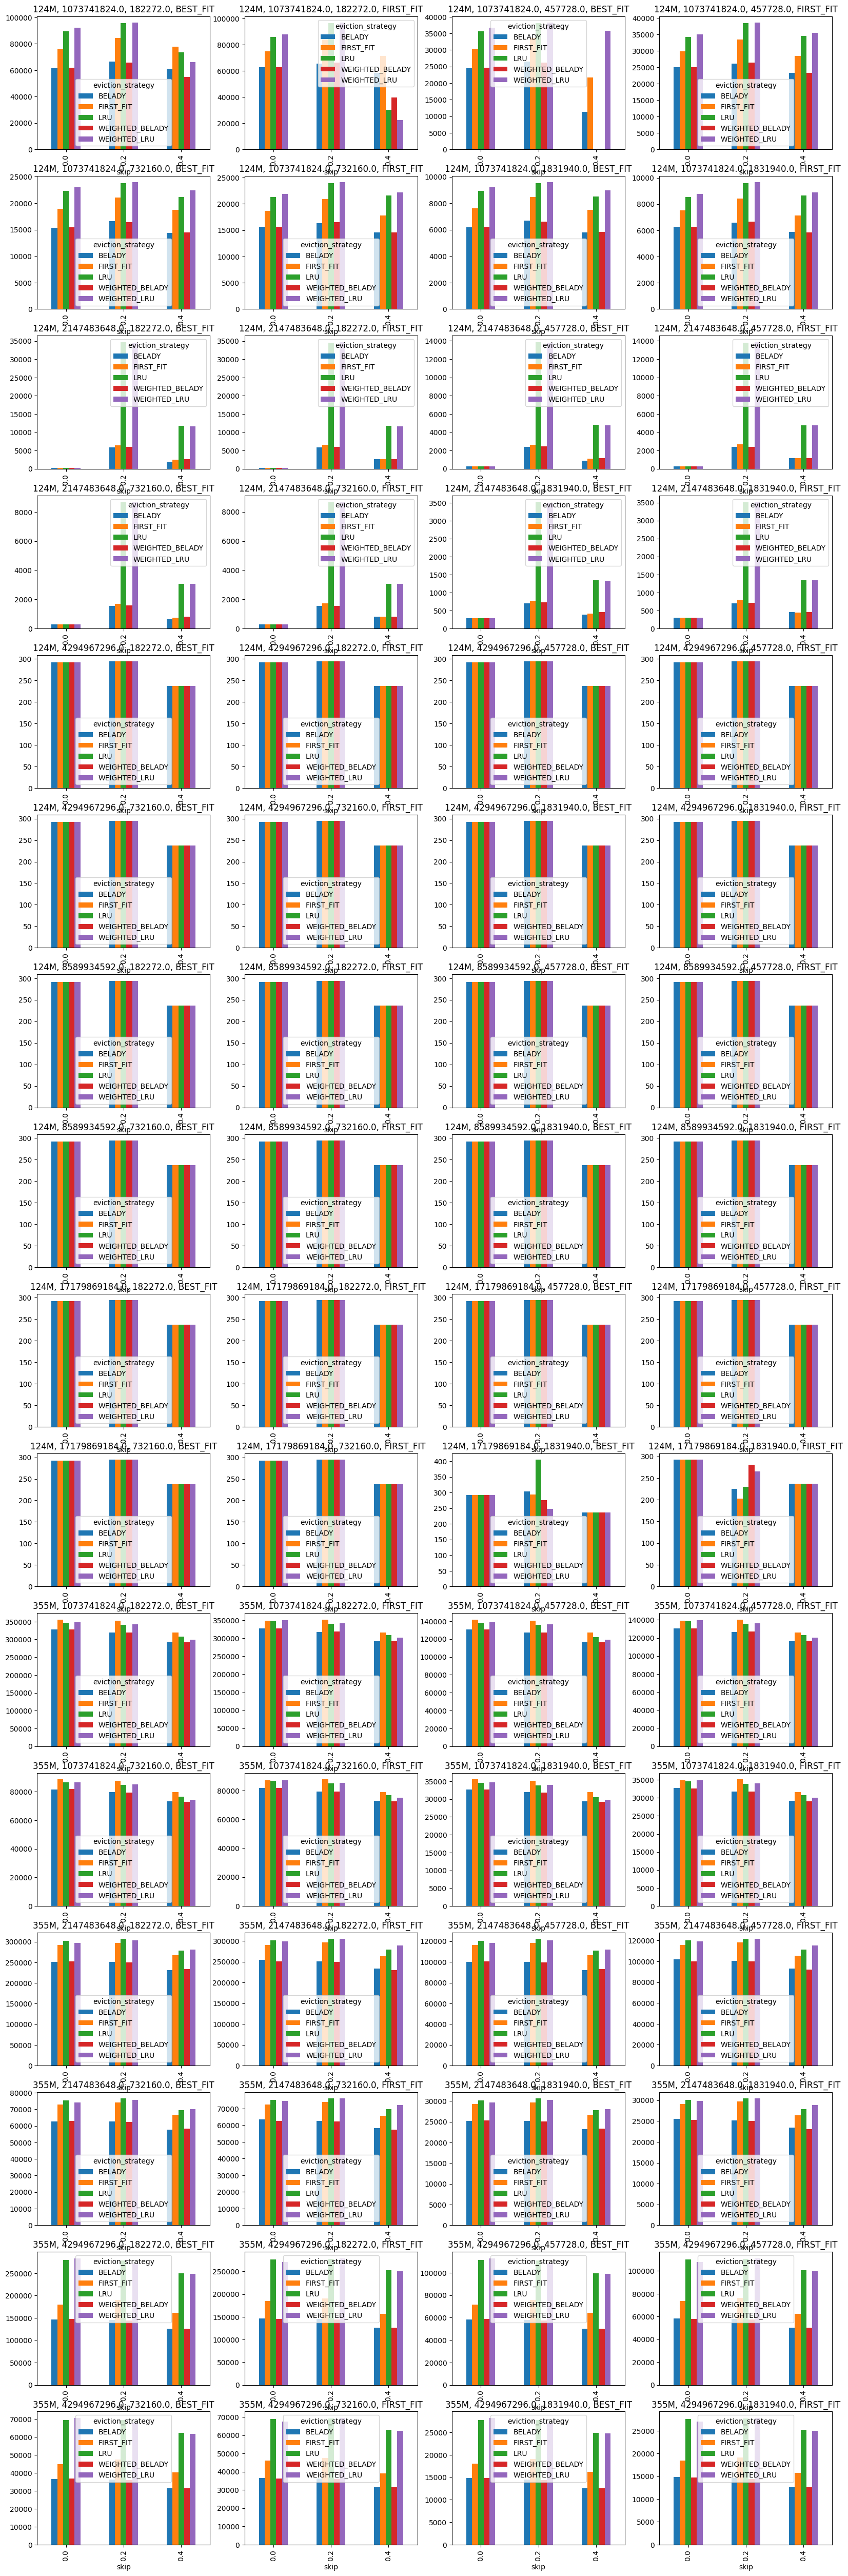

In [121]:
fig, axes = plt.subplots(16,4,figsize=(20,64))
for ((model_size, mem_limit, bandwidth, allocation_strategy), group), ax in zip(data.groupby(['model_size', 'mem_limit', 'bandwidth', 'allocation_strategy']), axes.flatten()):
    # try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
    group = group.sort_values('eviction_strategy')
    group = group.set_index(['skip', 'eviction_strategy'])['total_time'].unstack()
    group.plot.bar(ax=ax, title=f'{model_size}, {mem_limit}, {bandwidth}, {allocation_strategy}')

eviction_strategy
BELADY              88395.124354
FIRST_FIT          106368.049013
LRU                152772.483215
WEIGHTED_BELADY     88250.138577
WEIGHTED_LRU       148983.364782
Name: geomean, dtype: float64

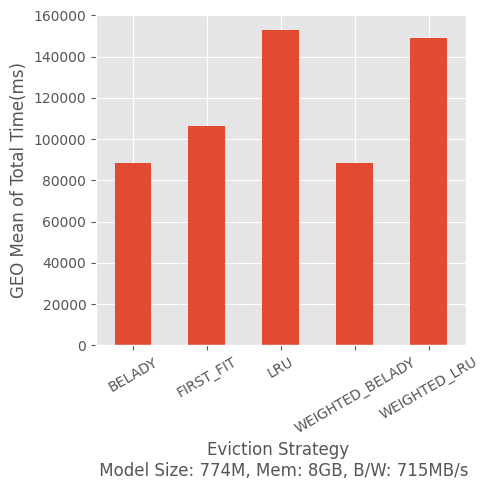

In [79]:
strategy_data = data[(data['total_time'] > 0 )& (data['model_size'] == '774M') & (data['mem_limit'] == 8 * (1024**3)) & (data['bandwidth'] == (715 * (1024))) & (data['eviction_strategy'] != 'FIRST_FIT')] 
strategy_data = strategy_data.set_index(['model_size', 'mem_limit', 'bandwidth', 'skip', 'allocation_strategy', 'eviction_strategy'])['total_time'].unstack()
strategy_data = strategy_data.T 
strategy_data 
strategy_data['geomean'] = strategy_data.apply(lambda x: x.prod()**(1/len(x)), axis=1)
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
strategy_data['geomean'].plot.bar(ax = ax, rot=30)
ax.set_xlabel('Eviction Strategy \n Model Size: 774M, Mem: 8GB, B/W: 715MB/s')
ax.set_ylabel('GEO Mean of Total Time(ms)')
fig.savefig('eviction_strategy.pdf')
fig.savefig('eviction_strategy.png')
strategy_data['geomean']